# Predicting the Success of Bank Telemarketing Campaigns

---

### **Goal:** 
Predict whether the customer will say **yes** or **no** to subscribing to a term deposit after a telemarketing call.

---

### **Input Variables:**

1. **Last Contact Date**: Date of the last contact during the campaign.  
2. **Age**: Age of the client.  
3. **Job**: Type of job.
4. **Marital**: Marital status.  
5. **Education**: Client's education level.  
6. **Default**: Whether the client has credit in default.  
7. **Balance**: Average yearly balance, in euros.  
8. **Housing**: Whether the client has a housing loan.  
9. **Loan**: Whether the client has a personal loan.  
10. **Contact**: Contact communication type.  
11. **Duration**: Duration of the last contact, in seconds.  
12. **Campaign**: Number of contacts made during this campaign.  
13. **Pdays**: Number of days since the client was last contacted in a previous campaign.  
14. **Previous**: Number of contacts made before this campaign.  
15. **Poutcome**: Outcome of the previous campaign.  

---

### **Output Variable (Target):**

16. **Target**: Whether the client subscribed to a term deposit.


## <a id="1"></a> <br> Table of Contents

1. [Import Required Libraries](#import-required-libraries)  
2. [Read the Data](#read-the-data)  
3. [Initial Data Exploration](#initial-data-exploration)  
   - 3.1 [Shape](#shape)  
   - 3.2 [Datatype](#datatype)  
   - 3.3 [Isnull](#isnull)  
   - 3.4 [Info](#info)
   - 3.5 [Duplicate Checking](#duplicate-checking)   
   - 3.6 [Categorical Columns](#categorical-columns)  
   - 3.7 [Numerical Columns](#numerical-columns)  
4. [Exploratory Data Analysis](#eda)  
   - 4.1 [Target Variable Analysis](#target-variable)  
   - 4.2 [Descriptive Statistics](#descriptive)  
   - 4.3 [Date/Time Variable Analysis](#date-analysis)  
   - 4.4 [Categorical Analysis](#categorical-analysis)  
       - [Chi-Square test](#chi)
       - [Comparison of Categorical Variables with Target](#categorical-target)
       - [Relationship between Job Types and Target](#job-target)   
   - 4.5 [Numerical Analysis](#numerical-analysis)  
       - [Correlation Heatmap between Numerical Columns and Target](#numeric-target) 
   - 4.6 [Mixed Data Analysis](#mixed-analysis)  
     - 4.6.1 [Visualize the Relationship between Age Group and Target](#age-target)    
     - 4.6.2 [Visualize the Relationship between Balance Range and Target](#balance-target) 
5. [Data Preprocessing](#data-preprocessing)  
   - 5.1 [Dropping Columns](#dropping-columns)  
   - 5.2 [Splitting Data](#splitting-data)  
   - 5.3 [Categorical Feature Preprocessing Pipeline](#cat-pipeline)  
   - 5.4 [Numerical Feature Preprocessing Pipeline](#num-pipeline)  
   - 5.5 [ColumnTransformer for Both Numerical and Categorical Columns](#columntransformer)  
   - 5.6 [Fitting and Transforming](#fit-transform)  
6. [Model Building](#model-building)  
   - 6.1 [Dummy Classifier](#dummy)  
   - 6.2 [Logistic Regression](#logistic)  
   - 6.3 [Random Forest](#random-fore)  
   - 6.4 [XGBoost](#xgboost)  
7. [Principal Component Analysis (PCA)](#pca)
8. [Recursive Feature Elimination (RFE)](#rfe)  
9. [Hyperparameter Tuning](#hyperparameter)  

    - [XGBoost Tuning](#xgb-tuning)
01. [Test Data Processing, Feature Selection, and Model Prediction with XGBoost](#test)


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


# <a id="import-required-libraries"></a> Import Required Libraries

In [3]:
# Importing Essential Libraries
import pandas as pd  
import numpy as np  

# Data Visualization Libraries
import matplotlib.pyplot as plt  
import seaborn as sns  

# test statistic
from scipy.stats import chi2_contingency

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')  

# sklearn for preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Build and train model
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# metrics
from sklearn.metrics import classification_report, f1_score, precision_recall_curve, average_precision_score

# dimensionality reduction
from sklearn.decomposition import PCA

# feature selection
from sklearn.feature_selection import RFE

# crossvalidation and hyperparameter tuning
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV

# saving model
import joblib

[Back to Table of Contents](#1)


# <a id="read-the-data"></a> 2. Read the Data


In [4]:
df = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
df

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39206,2008-07-31,31,technician,single,secondary,no,0,yes,no,cellular,16,34,-1,0,NaN,no
39207,2009-07-31,59,admin.,married,primary,no,6187,no,no,cellular,114,4,-1,0,NaN,no
39208,2008-06-02,36,blue-collar,married,secondary,no,63,yes,no,NaN,56,8,-1,0,NaN,no
39209,2010-03-20,28,student,single,secondary,no,5916,no,no,cellular,93,5,-1,0,NaN,no


# <a id="initial-data-exploration"></a> 3. Initial Data Exploration


### <a id="shape"></a>  *Shape*


In [5]:
print('Number of rows:',df.shape[0])
print('Number of features:',df.shape[1])

Number of rows: 39211
Number of features: 16


### <a id="datatype"></a>  *Datatype*

In [6]:
type(df)

pandas.core.frame.DataFrame

- Data is properly structured for analysis and is in form of `DataFrame`.

### <a id="isnull"></a>  *Isnull*

In [7]:
missing_values = df.isnull().sum()
percentage_missing = (missing_values / len(df)) * 100
percentage_missing[percentage_missing > 0]

job           0.584020
education     3.741297
contact      26.359950
poutcome     75.109026
dtype: float64

- Features like job,education,contact, and poutcome has null values. Other features has no null values

### <a id="info"></a>  *Info*

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

- 7 numerical (int64) and 9 categorical (object) columns.
- convert dtype of `last contact date` into datetime
- Here`target` is of object type and later it will encoded into binary.

In [9]:
df['last contact date'] = pd.to_datetime(df['last contact date'])

- changing `last contact date` column to a datetime dtype.

In [10]:
df['pdays'] = df['pdays'].replace(-1, 0)

- ‘-1’ which implies ‘not contacted’ is treated as numeric value. So I changed -1 to 0. This avoids confusion and helps the model treat the column correctly as numeric.

### <a id="duplicate-checking"></a>  *Duplicate checking*

In [11]:
df.duplicated().sum()

0

- No duplicated columns

### <a id="categorical-columns"></a>  *Categorical Columns*

In [12]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Categorical Columns:")
print("---------------------")
for col in categorical_cols:
    print(f"- {col}")

Categorical Columns:
---------------------
- job
- marital
- education
- default
- housing
- loan
- contact
- poutcome
- target


### <a id="numerical-columns"></a>  *Numerical Columns*

In [13]:
numerical_cols = df.select_dtypes(include=['int64']).columns.tolist()

print("Numerical Columns:")
print("------------------")
for col in numerical_cols:
    print(f"- {col}")

Numerical Columns:
------------------
- age
- balance
- duration
- campaign
- pdays
- previous


SUMMARY:
- There are 6 numerical and 9 categorical columns. The target variable is categorical.

[Back to Table of Contents](#1)

# <a id="eda"></a>  Exploratory Data Analysis

## <a id="target-variable"></a>1. Target Variable Analysis 

In [14]:
target_counts = df['target'].value_counts()
target_counts

target
no     33384
yes     5827
Name: count, dtype: int64

- Dataset is imbalanced.

## <a id="descriptive"></a> 2. Descriptive statistics

In [15]:
df.describe()

,last contact date,age,balance,duration,campaign,pdays,previous
count,39211,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,2009-06-22 21:10:55.254902784,42.120247,5441.781719,439.062789,5.108770,73.007013,11.826171
min,2008-01-01 00:00:00,18.000000,-8019.000000,0.000000,1.000000,0.000000,0.000000
25%,2008-08-11 00:00:00,33.000000,98.000000,109.000000,1.000000,0.000000,0.000000
50%,2009-06-05 00:00:00,40.000000,549.000000,197.000000,2.000000,0.000000,0.000000
75%,2010-05-08 00:00:00,50.000000,2030.000000,380.000000,4.000000,0.000000,0.000000
max,2010-12-30 00:00:00,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000
std,NaN,12.709352,16365.292065,769.096291,9.890153,160.600988,44.140259


### Insights:

- **last contact date:** Data was gathered over 3 years, with half of the dataset collected in the first half of the time span, indicating a consistent collection effort throughout the period.
- **age:** The minimum and maximum values in the age column show that customers range from young adults to seniors, with no minors. The median age is 40, meaning half of the clients are older, and half are younger.
- **balance:** The balance column reflects customers from diverse financial backgrounds. Most customers tend to maintain lower balances.
- **duration:** The call duration ranges from a minimum of 0 seconds to a maximum of 1.5 hours, indicating a significant variation in call lengths.
- **campaign:** 75% of clients were contacted up to four times. The maximum value of 63 in the campaign column suggests a few clients were contacted 63 times, which would be considered an anomaly in real-world scenarios. so i deal with it manually.
- **pdays**: All percentile values are `0`, indicating that most clients were not previously contacted.
- **previous**: All percentile values are `0`, indicating no contact made.

> **Mean > Median indicates a right-skewed distribution**

In [16]:
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,poutcome,target
count,38982,39211,37744,39211,39211,39211,28875,9760,39211
unique,11,3,3,2,2,2,2,3,2
top,blue-collar,married,secondary,no,yes,no,cellular,failure,no
freq,7776,22691,19584,36954,21657,31820,25030,4949,33384


#### Insights of Distribution Imbalance of Categorical Variables

| Column      | Distribution Insights                                                                                                                       | Imbalanced |
|-------------|--------------------------------------------------------------------------------------------------------------------------------------------------------|------------|
| Job         | Certain job categories like "blue-collar" have a high frequency, while other categories are less common.                                              | Yes        |
| Marital     | "Married" is the dominant category, with "Single" and "Divorced" less frequent but still notable.                                                   | Yes        |
| Education   | "Secondary" is the dominant category, but "Tertiary" and "Primary" also have significant counts.                                                     | Yes        |
| Default     | "No" dominates, with very few "Yes" entries.                                                                                                        | Yes        |
| Housing     | "Yes" is dominant, but "No" also has a noticeable presence.                                                                                        | Yes        |
| Loan        | "No" dominates, indicating a binary imbalance in the distribution.                                                                                  | Yes        |
| Contact     | "Cellular" is the dominant category, with other categories having minimal frequency.                                                               | Yes        |
| Poutcome    | "Unknown" holds high frequency, while "Failure" and "Success" are less common.                                                                     | Yes        |
| Target      | "No" significantly outweighs "Yes," with the majority of clients not subscribing to a term deposit.                                                  | Yes        |


[Back to Table of Contents](#1)

## <a id="date-analysis"></a> 3. Date/Time Variables Analysis

#### <a id="cat-univariate"></a>  *Last Contact Date Feature*


In [17]:
df['year'] = df['last contact date'].dt.year
df['month'] = df['last contact date'].dt.month_name()
df['day'] = df['last contact date'].dt.day
df['day_of_week'] = df['last contact date'].dt.day_name()

- Transformations on `last contact date` are performed to extract informations.

**`year`**

In [18]:
# Analysis by Year
year_counts = df['year'].value_counts().sort_index()
year_counts

year
2008    13116
2009    12948
2010    13147
Name: count, dtype: int64

- This states that each year the activity to get customers are somewhat near to each other.

In [19]:
# Chi-Square Test for 'year' and 'target'
contingency_table = pd.crosstab(df['year'], df['target'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square p-value for Year vs Target: {p}")

Chi-Square p-value for Year vs Target: 0.9119836563966235


- pvalue > 0.05(Accept null hypothesis). This indicates that there is no significant association between the year and the target variable. so drop it.

**month**

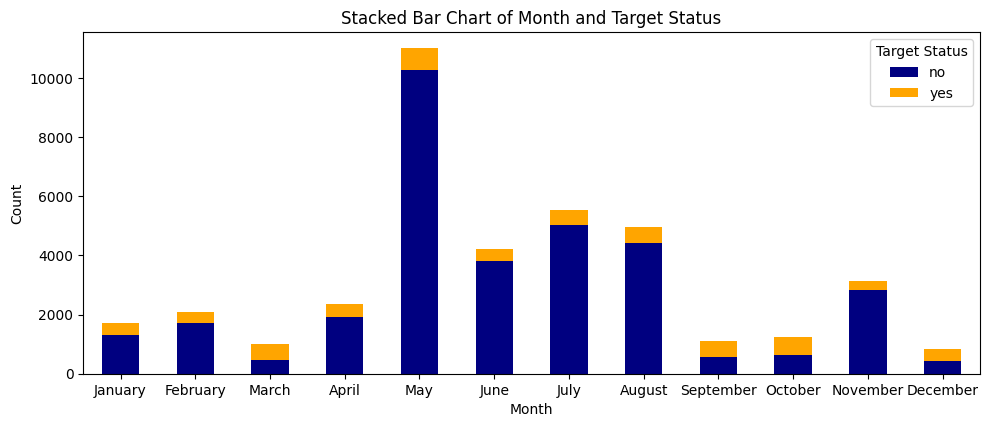

In [20]:
#Stacked Bar Chart: Frequency distribution of Month and Target Status
contingency_table_month = pd.crosstab(df['month'], df['target'], margins=False)

plt.figure(figsize=(10, 5))
contingency_table_month.reindex(
    ['January', 'February', 'March', 'April', 'May', 'June', 
     'July', 'August', 'September', 'October', 'November', 'December']
).plot(kind='bar', stacked=True, color=['Navy', 'Orange'], ax=plt.gca())

plt.title('Stacked Bar Chart of Month and Target Status')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Target Status', loc='upper right')
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

- May shows a big increase in customer engagement, probably because it's the start of the bank's financial year. This suggests the bank puts more effort into contacting new customers at this time.
- After May, the activity drops.
- March, September, and October with relatively balanced response rates. These months might focused on clients to respond positively.
- May,June,July, August and November have high negative responses.

**day_of_week**

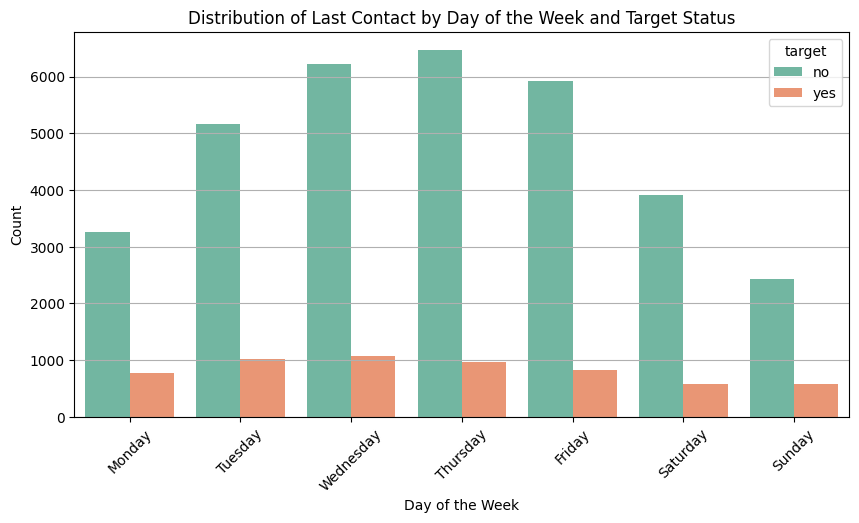

In [21]:
# Counter Plot : Distribution of Last Contact by Day of the Week and Target

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)

plt.figure(figsize=(10, 5))
sns.countplot(x='day_of_week', hue='target', data=df, palette='Set2')
plt.title('Distribution of Last Contact by Day of the Week and Target Status')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.grid(axis='y')
plt.show()

- Wednesday and Thursday shows the highest contact volume.
- Monday has balanced responses but lower contact volume, indicating potential for early-week targeting.
- Friday has a higher proportion of non-subscribers, suggesting less effective outreach towards the end of the week.
- Weekends (Saturday and Sunday) have lower contact volumes but higher subscription rates, suggesting targeted strategies could be effective.

[Back to Table of Contents](#1)

## <a id="categorical-analysis"></a>4. Categorical Analysis

In [22]:
df_vis = df.copy()

In [23]:
df_vis['job'].fillna('unknown', inplace=True)
df_vis['education'].fillna('unknown', inplace=True)
df_vis['poutcome'].fillna('unknown', inplace=True)
df_vis['contact'].fillna('unknown', inplace=True)

- To handle missing values, I filled the missing values with "unknown" for visualization purposes. Later, I used an imputation method to fill in the missing values with a more appropriate value.

## <a id="chi"></a> *Chi-Square test*


In [24]:
categorical_columns = ['contact', 'poutcome', 'loan', 'housing', 'default', 'education', 'marital', 'job']

# Chi-Square test
for column in categorical_columns:
    contingency_table = pd.crosstab(df_vis[column], df_vis['target'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square p-value for {column} vs Target: {p:}")

Chi-Square p-value for contact vs Target: 0.0
Chi-Square p-value for poutcome vs Target: 0.0
Chi-Square p-value for loan vs Target: 1.5232115241364981e-05
Chi-Square p-value for housing vs Target: 2.6434491320142085e-144
Chi-Square p-value for default vs Target: 4.534708981631268e-218
Chi-Square p-value for education vs Target: 8.44828342860415e-40
Chi-Square p-value for marital vs Target: 5.8338232683734595e-89
Chi-Square p-value for job vs Target: 0.0


- All categorical columns show very strong associations with the target variable and should be prioritized in modeling.

## <a id="categorical-target"></a> *Comparison of Categorical Variables with Target*

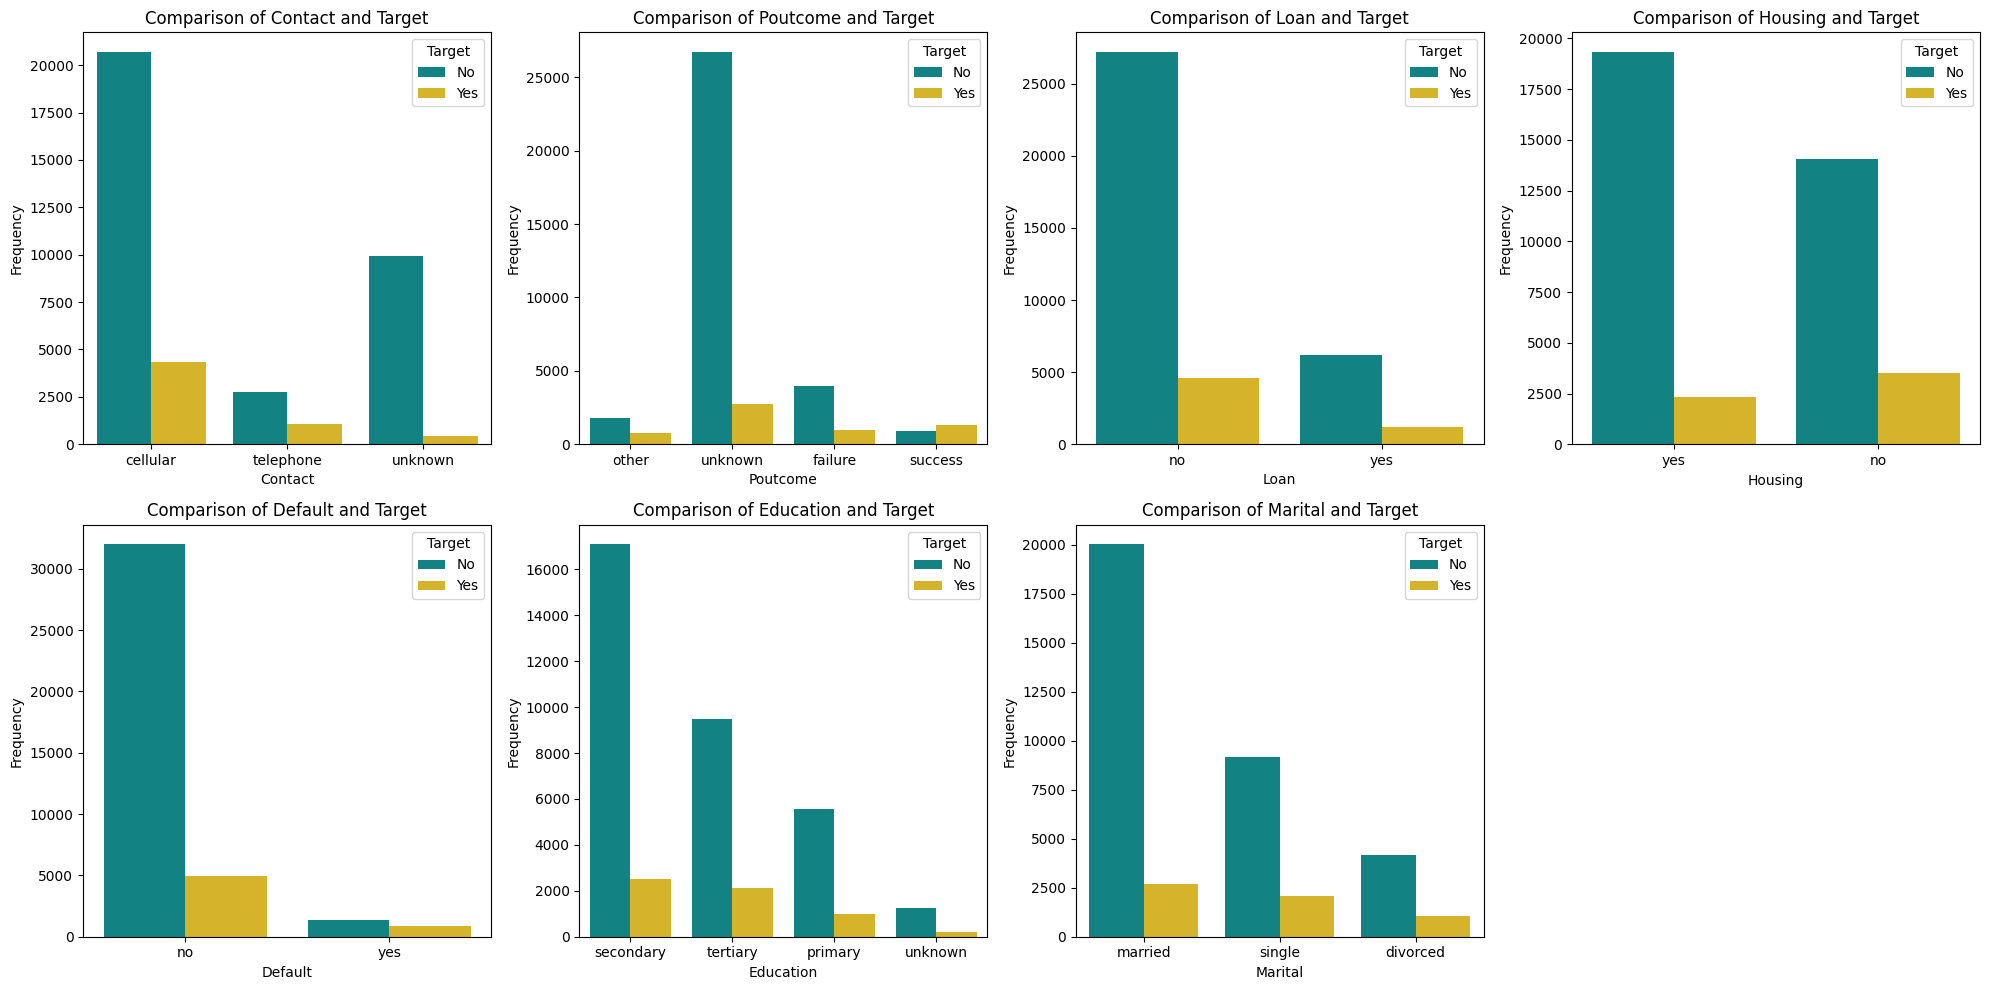

In [25]:
categorical_columns1 = ['contact', 'poutcome', 'loan', 'housing', 'default', 'education', 'marital']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

#countplot
for i, column in enumerate(categorical_columns1):
    sns.countplot(data=df_vis, x=column, hue='target', palette=['#009596', '#f1c40f'], ax=axes[i])
    axes[i].set_title(f'Comparison of {column.capitalize()} and Target')
    axes[i].set_xlabel(column.capitalize())
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].legend(title='Target', labels=['No', 'Yes'])

axes[7].axis('off')
plt.tight_layout()
plt.show()
# All categorical columns exhibit an imbalanced distribution of categories.

**Insights on Relationship Between Categorical Variables and Target**

1. **Contact and Target:** Although telephone contact is used less, the likelihood of getting a 'yes' as the target is nearly double compared to other methods. Therefore, shifting the contact method to telephone could improve customer engagement and increase subscription rates.

2. **Poutcome and Target:** "success" in the previous campaign is strongly associated with a higher subscription rate (target = 'yes'). In contrast, "failure" and "unknown" outcomes are less predictive of success. Thus, past campaign performance is a key factor in predicting future subscriptions.

3. **Loan and Target:** Clients with no loan are more likely to subscribe to the term deposit.

4. **Housing and Target:** Clients with a housing loan have a much higher frequency of "No" for target subscription.

5. **Default and Target:** Clients with no credit default are more likely to subscribe to a term deposit.

6. **Education and Target:** Clients with tertiary education have higher subscription rates. A large number of clients have secondary education, but their subscription rates are lower compared to those with tertiary education.

7. **Marital and Target:** Most clients are married, and they show a higher frequency of not subscribing to the term deposit, likely due to financial stability.

## <a id="job-target"></a> *Relationship between job types and target*

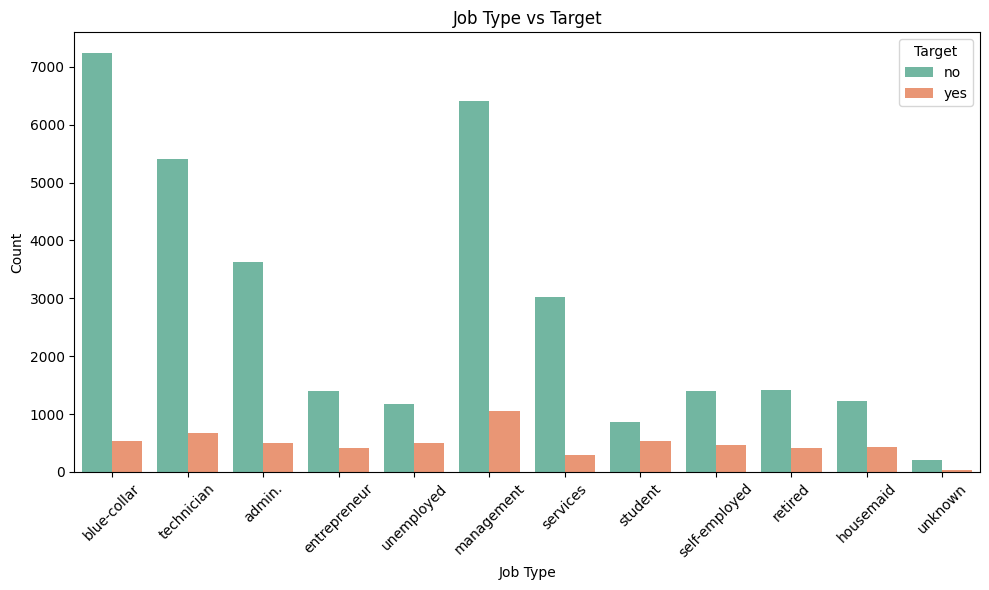

In [26]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_vis, x='job', hue='target', palette='Set2')
plt.title('Job Type vs Target')
plt.xlabel('Job Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Target')
plt.tight_layout()
plt.show()

- student & self-employed: Small contacted groups with strong positive target rates. Increasing outreach here could yield more subscriptions.
- management & technician: High positive responses but also high negative rates. Consider refining marketing efforts to boost conversion in these groups.
- blue-collar & services: Large groups with lower engagement ("yes" responses).


[Back to Table of Contents](#1)

## <a id="numerical-analysis"></a> 5. Numerical Analysis

### <a id="numeric-target"></a>  Correlation Heatmap between Numerical Columns and Target


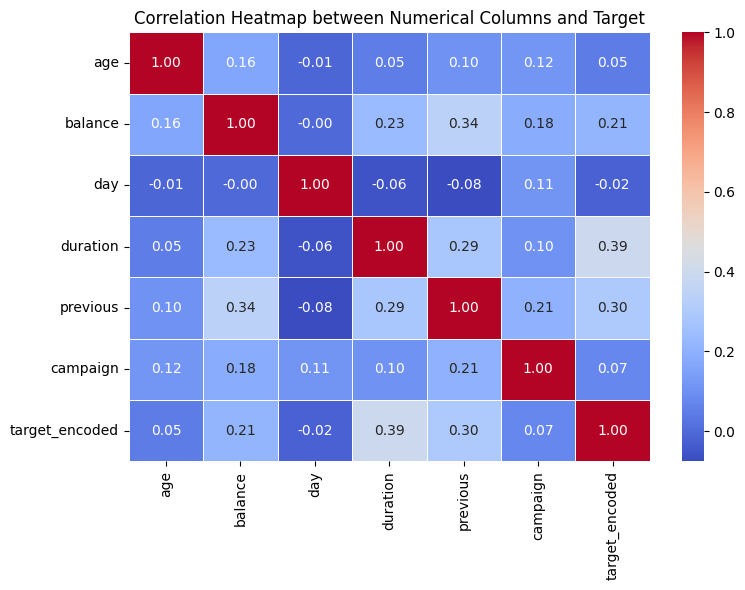

In [27]:
df['target_encoded'] = df['target'].map({'no': 0, 'yes': 1})

# Correlation matrix
correlation_matrix = df[['age', 'balance','day','duration','previous', 'campaign', 'target_encoded']].corr(method='spearman')
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap between Numerical Columns and Target')
plt.tight_layout()
plt.show()

- **Age**: Weak correlation suggests age is not a critical factor in predicting subscription, but age group segmentation could provide more insights.
- **Balance**: Moderate positive correlation indicates wealthier clients with higher balances are more likely to subscribe.
- **Days Since Last Contact**: Very weak correlation shows recent contact is not a key factor; other campaign factors may be more important.
- **Campaign**: Weak positive correlation suggests more contacts during the campaign slightly increase the chances of subscription, highlighting the importance of sustained outreach.

[Back to Table of Contents](#1)

## <a id="mixed-analysis"></a>  6. Mixed Data Analysis with Target variable


### <a id="age-target"></a> *Visualize the relationship between Age group and Target*

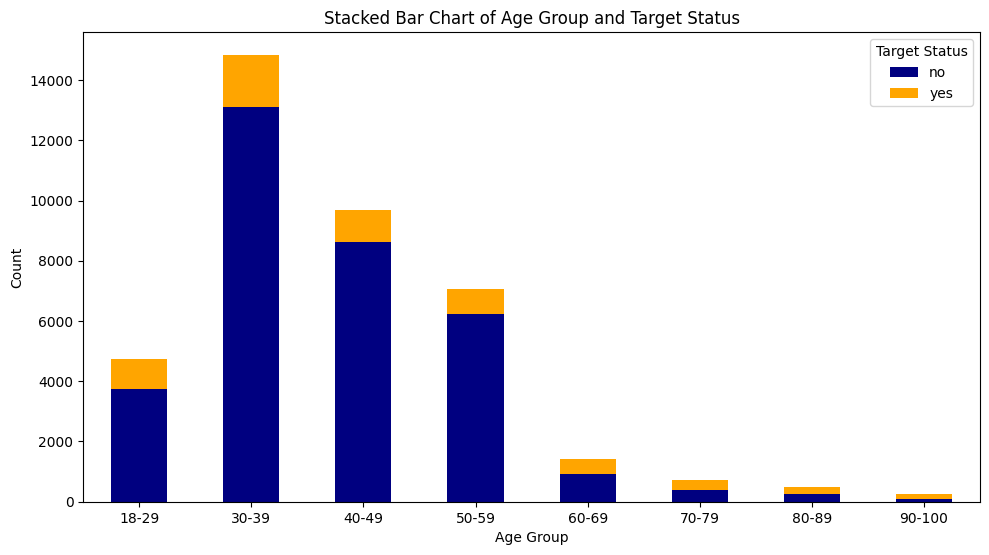

In [28]:
bins = [18, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-100']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

contingency_table_age = pd.crosstab(df['age_group'], df['target'], margins=False)

# Stacked bar chart
plt.figure(figsize=(10, 6))
contingency_table_age.plot(kind='bar', stacked=True, color=['Navy', 'Orange'], ax=plt.gca())

plt.title('Stacked Bar Chart of Age Group and Target Status')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Target Status', loc='upper right')
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

- Younger age groups (20-29) show lower subscription rates, likely due to financial instability or a lack of awareness.
- (30-59) age groups still represent a large portion of the client base but subscription rate isn't extremely high.
- 
Subscription rates increase as age increases, particularly in the 60+ age groups, where clients are likely more focused on secure financial products
- 
The elderly population (70+) shows a strong preference for term deposits, possibly for stability in retirement.

### <a id="balance-target"></a> *Visualize the relationship between Balance range and Target*


In [29]:
bins = [df['balance'].min(), 0, df['balance'].quantile(0.25), df['balance'].quantile(0.75), df['balance'].max()]
labels = ['Negative', 'Low', 'Medium', 'High']
df['balance_range'] = pd.cut(df['balance'], bins=bins, labels=labels, include_lowest=True)

In [30]:
contingency_table_bal = pd.crosstab(df['balance_range'], df['target'], margins=False)

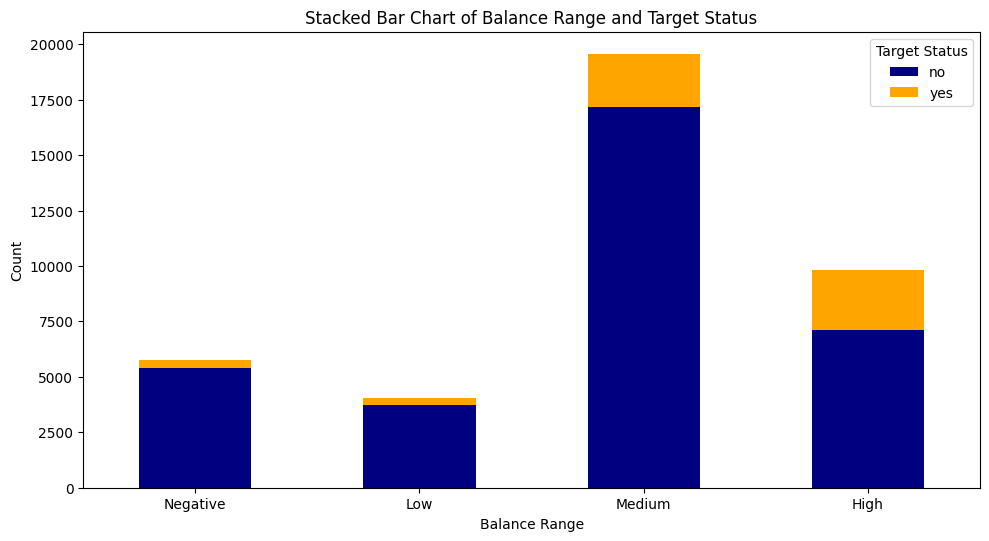

In [31]:
plt.figure(figsize=(10, 6))
contingency_table_bal.plot(kind='bar', stacked=True, color=['Navy', 'Orange'], ax=plt.gca())
plt.title('Stacked Bar Chart of Balance Range and Target Status')
plt.xlabel('Balance Range')
plt.ylabel('Count')
plt.legend(title='Target Status', loc='upper right')
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

- With negative or low balances show a stronger trend of not subscribing to the term deposit, which makes sense given their financial constraints.
- Customer with medium to high balances have a higher likelihood of subscribing to the term deposit.
- The majority of clients in all balance categories (except the very low ones) still did not subscribe, indicating that factors beyond the balance itself influence subscription behavior.

In [32]:
df = df.drop(['target_encoded', 'age_group', 'balance_range'], axis=1)
df.columns

Index(['last contact date', 'age', 'job', 'marital', 'education', 'default',
       'balance', 'housing', 'loan', 'contact', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'target', 'year', 'month', 'day',
       'day_of_week'],
      dtype='object')

[Back to Table of Contents](#1)

# <a id="data-preprocessing"></a>  Data Preprocessing

In [33]:
df1 = df.copy()

### <a id="dropping-columns"></a>  *1. Dropping Columns*

In [34]:
columns_to_drop = ['last contact date','year']
df1 = df.drop(columns=columns_to_drop)

- As we already used `last contact date` feature and extracted needed details.
- `year` has no relation with target


### <a id="splitting-data"></a>  *2. Splitting Data*


In [35]:
target_column = 'target'
X = df1.drop(target_column, axis=1)
y = df1[target_column] 

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_valid:", X_valid.shape)
print("Shape of y_train:", y_valid.shape)

Shape of X_train: (31368, 17)
Shape of y_train: (31368,)
Shape of X_valid: (7843, 17)
Shape of y_train: (7843,)


In [38]:
categorical_cols = X_train.select_dtypes(include=['object','category']).columns
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

### <a id="cat-pipeline"></a>  *3. Categorical Feature Preprocessing Pipeline*

In [39]:
X_train['poutcome'] = X_train['poutcome'].fillna('unknown')

In [40]:
one_hot_cols = ['job', 'marital', 'contact']
ordinal_cols_edu = ['education']
ordinal_cols = ['month', 'day_of_week', 'poutcome','default', 'housing', 'loan']
education_order = [['primary', 'secondary', 'tertiary']]

# one-hot encoding
one_hot_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# ordinal encoding (education)
ordinal_pipeline_edu = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=education_order))
])

ordinal_pipelines = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

# ColumnTransformer 
categorical_transformer = ColumnTransformer([
    ('onehot', one_hot_pipeline, one_hot_cols),
    ('ordinal_edu', ordinal_pipeline_edu, ordinal_cols_edu),
    ('ordinal', ordinal_pipelines, ordinal_cols)    
], remainder='passthrough')

In [41]:
categorical_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['job', 'marital', 'contact']),
                                ('ordinal_edu',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder(categories=[['primary',
                                                                              'secondary',
                                                                              'tertiary']]))]),
                                 ['education']),
                                ('ordinal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder())]),
                                 ['month', 'day_of_week', 'poutcome', 'default',
                                  'housing', 'loan'])])

### <a id="num-pipeline"></a>  *5. Numerical Feature Preprocessing Pipeline*

In [42]:
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', StandardScaler())  
])

In [43]:
numerical_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

### <a id="column-transformer"></a>  *6. ColumnTransformer for both numerical and categorical columns*

In [44]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


### <a id="fit-transform"></a>  *7. Fitting and Transforming*

In [45]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_valid_transformed = preprocessor.transform(X_valid)

In [46]:
print(X_train_transformed.shape)
print(X_train.shape) 

(31368, 29)
(31368, 17)


In [47]:
y_train_encoded = y_train.map({'yes': 1, 'no': 0})
y_valid_encoded = y_valid.map({'yes': 1, 'no': 0})

[Back to Table of Contents](#1)

# <a id="model-building"></a> 6. Model Building

### <a id="dummy"></a> 1. Dummy classifier

In [48]:
dummy_model = DummyClassifier(strategy="stratified", random_state=42)
dummy_model.fit(X_train_transformed, y_train_encoded)

# Make predictions
y_pred_dummy = dummy_model.predict(X_valid_transformed)

#Evaluate
print("Dummy Classifier Classification Report:")
print(classification_report(y_valid_encoded, y_pred_dummy))

Dummy Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      6677
           1       0.14      0.14      0.14      1166

    accuracy                           0.75      7843
   macro avg       0.49      0.49      0.49      7843
weighted avg       0.74      0.75      0.74      7843



> - Predicting class 0 (non-subscriber): As it is the larger class in the dataset, this causes the model to perform well for class 0, with high precision and recall.
> - Predicting class 1 (subscriber): The low precision and recall for class 1 show that the model is not good at identifying subscribers, which is the main goal of the model.
> - As the model predict majority class well, it obtain model's accuracy 0.74

### <a id="logistic"></a> 2. Logistic Regression

In [49]:
logistic_model = LogisticRegression(penalty='l2',random_state=42, max_iter=1000, class_weight='balanced')
logistic_model.fit(X_train_transformed, y_train_encoded)

# Make predictions
y_pred_logistic = logistic_model.predict(X_valid_transformed)

#Evaluate
print("Logistic Regression Classification Report:")
print(classification_report(y_valid_encoded, y_pred_logistic))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      6677
           1       0.40      0.71      0.51      1166

    accuracy                           0.80      7843
   macro avg       0.67      0.76      0.69      7843
weighted avg       0.86      0.80      0.82      7843



> - The precision for subcriber is low, which means it misses many actual subscribers.
> - The model does not detect all non-subscribers (class 0), resulting in a slightly lower recall for non-subscribers.
> - Accuracy influenced by the dominance of non-subscribers (class 0)

### <a id="random-forest"></a> 3.Random Forest

In [50]:
random_forest_model = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 2})
random_forest_model.fit(X_train_transformed, y_train_encoded)

# Make predictions
y_pred_rf = random_forest_model.predict(X_valid_transformed)

# Evaluate
print("Random Forest Classification Report:")
print(classification_report(y_valid_encoded, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      6677
           1       0.60      0.39      0.47      1166

    accuracy                           0.87      7843
   macro avg       0.75      0.67      0.70      7843
weighted avg       0.86      0.87      0.86      7843



> - Class 0 Performance: High precision, recall, and F1-score. The model identifies class 0 instances very effectively.
> - Class 1 Performance: Lower precision, recall, and F1-score, indicating difficulty in correctly identifying and predicting the minority class.

### <a id="xgboost"></a> 4. XGBoost

In [51]:
xgb_model = XGBClassifier(scale_pos_weight=3, eval_metric='logloss')
xgb_model.fit(X_train_transformed, y_train_encoded)

# Make predictions
y_pred_xgb = xgb_model.predict(X_valid_transformed)

# Evaluate the model
print("XGBoost Classification Report:")
print(classification_report(y_valid_encoded, y_pred_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      6677
           1       0.51      0.71      0.59      1166

    accuracy                           0.86      7843
   macro avg       0.73      0.79      0.75      7843
weighted avg       0.88      0.86      0.87      7843



> - XGBoost performs better than Random Forest on the minority class (class 1) and model remains effective at identifying the majority class.
> - While the overall accuracy is 86%, slightly lower than Random Forest, XGBoost balances the trade-off between the majority and minority classes, as reflected in its macro average F1-score (0.76)

[Back to Table of Contents](#1)

# <a id="pca"></a> 7. Principal Component Analysis (PCA)

In [52]:
pca = PCA()
X_train_pca = pca.fit(X_train_transformed)

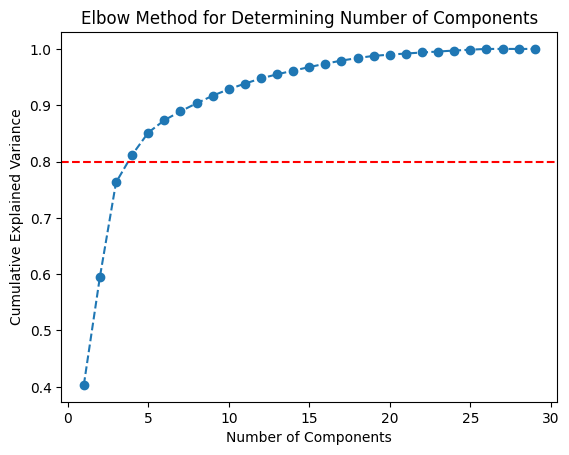

In [53]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Method for Determining Number of Components')
plt.axhline(y=0.80, color='r', linestyle='--')  
plt.show()

- Selected 3 components because they cover 80% of data for the model.

In [54]:
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_transformed)
X_valid_pca = pca.transform(X_valid_transformed)

### **Logistic Regression with PCA**

In [55]:

logistic_model_pca = LogisticRegression(random_state=42, max_iter=10000, class_weight='balanced')
logistic_model_pca.fit(X_train_pca, y_train_encoded)

y_pred_logistic_pca = logistic_model_pca.predict(X_valid_pca)

# Evaluate Logistic Regression with PCA
print("Logistic Regression Classification Report with PCA:")
print(classification_report(y_valid_encoded, y_pred_logistic_pca))


Logistic Regression Classification Report with PCA:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      6677
           1       0.32      0.41      0.36      1166

    accuracy                           0.78      7843
   macro avg       0.61      0.63      0.61      7843
weighted avg       0.81      0.78      0.79      7843



### **Random Forest with PCA**

In [56]:
random_forest_model_pca = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 2})
random_forest_model_pca.fit(X_train_pca, y_train_encoded)

y_pred_rf_pca = random_forest_model_pca.predict(X_valid_pca)

# Evaluate Random Forest with PCA
print("Random Forest Classification Report with PCA:")
print(classification_report(y_valid_encoded, y_pred_rf_pca))

Random Forest Classification Report with PCA:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      6677
           1       0.52      0.27      0.35      1166

    accuracy                           0.85      7843
   macro avg       0.70      0.61      0.64      7843
weighted avg       0.83      0.85      0.83      7843



### **XGBoost with PCA**

In [57]:
#  XGBoost 
xgb_model_pca = XGBClassifier(scale_pos_weight=3, eval_metric='logloss')
xgb_model_pca.fit(X_train_pca, y_train_encoded)

y_pred_xgb_pca = xgb_model_pca.predict(X_valid_pca)

# Evaluate XGBoost with PCA
print("XGBoost Classification Report with PCA:")
print(classification_report(y_valid_encoded, y_pred_xgb_pca))


XGBoost Classification Report with PCA:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      6677
           1       0.45      0.60      0.52      1166

    accuracy                           0.83      7843
   macro avg       0.69      0.74      0.71      7843
weighted avg       0.86      0.83      0.84      7843



> - Without PCA: The model has a better F1 macro score, suggesting better overall performance across both classes.
>- With PCA: Performance is worse, especially for class 1, due to reduced identification ability as all the columns having high relationship with target.
> - #### Overall model works good without PCA

[Back to Table of Contents](#1)

# <a id="rfe"></a> 8. Recursive Feature Elimination (RFE)

In [58]:
n_features_to_select =15

### **Logistic Regression with RFE**


In [60]:
# Logistic Regression with RFE
rfe_logistic = RFE(estimator=logistic_model, n_features_to_select=n_features_to_select)
X_train_rfe_logistic = rfe_logistic.fit_transform(X_train_transformed, y_train_encoded)
X_valid_rfe_logistic = rfe_logistic.transform(X_valid_transformed)

logistic_model.fit(X_train_rfe_logistic, y_train_encoded)
y_pred_logistic_rfe = logistic_model.predict(X_valid_rfe_logistic)

print("Logistic Regression with RFE:")
print(classification_report(y_valid_encoded, y_pred_logistic_rfe))

Logistic Regression with RFE:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      6677
           1       0.40      0.71      0.51      1166

    accuracy                           0.80      7843
   macro avg       0.67      0.76      0.69      7843
weighted avg       0.86      0.80      0.82      7843



- Imbalanced: Strong performance for class 0 (high precision and recall), but poor for class 1 (low precision).

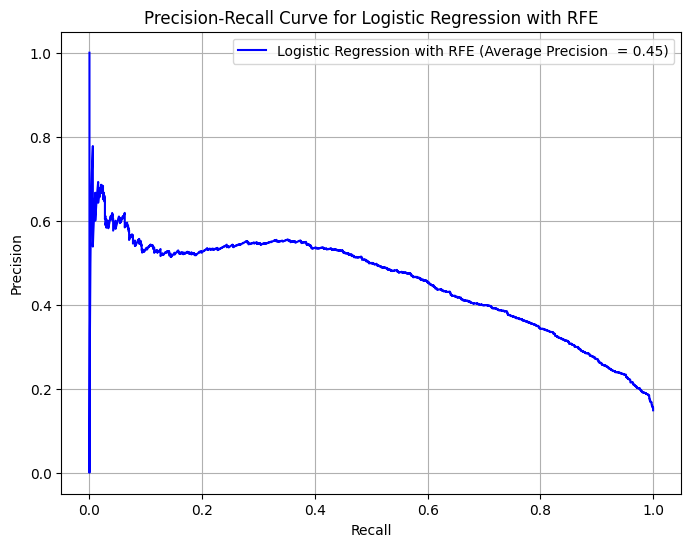

In [76]:
y_pred_prob_logistic_rfe = logistic_model.predict_proba(X_valid_rfe_logistic)[:, 1]
precision, recall, _ = precision_recall_curve(y_valid_encoded, y_pred_prob_logistic_rfe)
average_precision = average_precision_score(y_valid_encoded, y_pred_prob_logistic_rfe)

# Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"Logistic Regression with RFE (Average Precision = {average_precision:.2f})", color="blue")
plt.title("Precision-Recall Curve for Logistic Regression with RFE")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.grid()
plt.show()


- The Average Precision (AP) score of 0.45 indicates that the model has a moderate performance in terms of precision and recall.
- The curve shows a typical trade-off between precision and recall. As recall increases, precision tends to decrease, and vice versa. This is because the model is more likely to include more false positives as it tries to capture more true positives.
- As recall increases, precision starts to decline. This indicates that the model is including more false positives along with true positives.


### **Random Forest with RFE**

In [62]:
# Random Forest with RFE
rfe_rf = RFE(estimator=random_forest_model, n_features_to_select=n_features_to_select)
X_train_rfe_rf = rfe_rf.fit_transform(X_train_transformed, y_train_encoded)
X_valid_rfe_rf = rfe_rf.transform(X_valid_transformed)

random_forest_model.fit(X_train_rfe_rf, y_train_encoded)
y_pred_rf_rfe = random_forest_model.predict(X_valid_rfe_rf)

print("Random Forest with RFE")
print(classification_report(y_valid_encoded, y_pred_rf_rfe))

Random Forest with RFE
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      6677
           1       0.62      0.39      0.48      1166

    accuracy                           0.87      7843
   macro avg       0.76      0.67      0.70      7843
weighted avg       0.86      0.87      0.86      7843



- Class 0 dominance: High recall for class 0, but low recall for class 1, causing class imbalance.

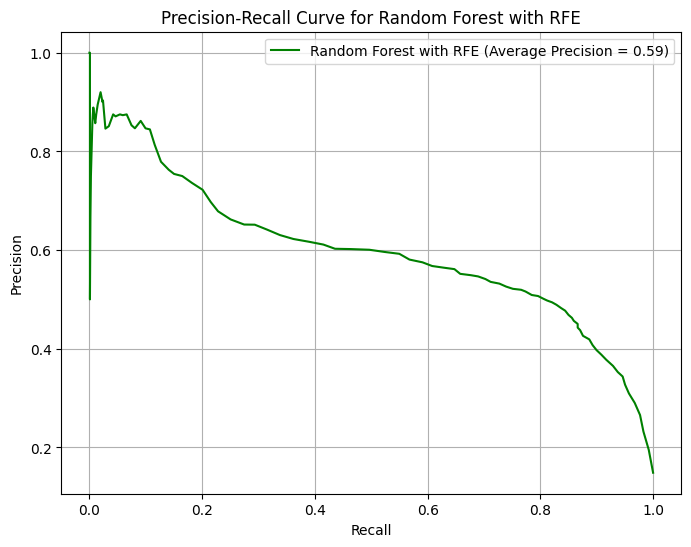

In [77]:
y_pred_prob_rf_rfe = random_forest_model.predict_proba(X_valid_rfe_rf)[:, 1]
precision_rf, recall_rf, _ = precision_recall_curve(y_valid_encoded, y_pred_prob_rf_rfe)
average_precision_rf = average_precision_score(y_valid_encoded, y_pred_prob_rf_rfe)

# Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, label=f"Random Forest with RFE (Average Precision = {average_precision_rf:.2f})", color="green")
plt.title("Precision-Recall Curve for Random Forest with RFE")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.grid()
plt.show()


- The Average Precision (AP) score of 0.58 indicates that the model has a moderate performance in terms of precision and recall.
- The curve shows a typical trade-off between precision and recall. As recall increases, precision tends to decrease, and vice versa. This is because the model is more likely to include more false positives as it tries to capture more true positives.
- As recall increases, precision starts to decline. This indicates that the model is including more false positives along with true positives.




### **XGBoost with RFE**

In [64]:
# XGBoost with RFE
rfe_xgb = RFE(estimator=xgb_model, n_features_to_select=n_features_to_select)
X_train_rfe_xgb = rfe_xgb.fit_transform(X_train_transformed, y_train_encoded)
X_valid_rfe_xgb = rfe_xgb.transform(X_valid_transformed)

xgb_model.fit(X_train_rfe_xgb, y_train_encoded)
y_pred_xgb_rfe = xgb_model.predict(X_valid_rfe_xgb)

print("XGBoost with RFE")
print(classification_report(y_valid_encoded, y_pred_xgb_rfe))

XGBoost with RFE
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      6677
           1       0.52      0.72      0.60      1166

    accuracy                           0.86      7843
   macro avg       0.73      0.80      0.76      7843
weighted avg       0.88      0.86      0.87      7843



- Balanced performance: Better recall and precision for both classes, the best overall balance between class 0 and class 1.

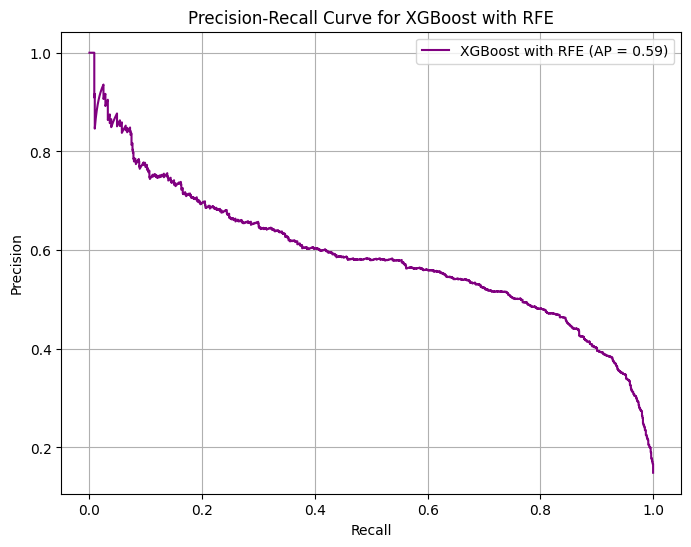

In [65]:
y_pred_prob_xgb_rfe = xgb_model.predict_proba(X_valid_rfe_xgb)[:, 1]
precision_xgb_rfe, recall_xgb_rfe, _ = precision_recall_curve(y_valid_encoded, y_pred_prob_xgb_rfe)
average_precision_xgb_rfe = average_precision_score(y_valid_encoded, y_pred_prob_xgb_rfe)

# Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_xgb_rfe, precision_xgb_rfe, label=f"XGBoost with RFE (AP = {average_precision_xgb_rfe:.2f})", color="purple")
plt.title("Precision-Recall Curve for XGBoost with RFE")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.grid()
plt.show()


- The Average Precision (AP) score of 0.59 indicates that the model has a moderate performance in terms of precision and recall.
- The curve shows a typical trade-off between precision and recall. As recall increases, precision tends to decrease, and vice versa. This is because the model is more likely to include more false positives as it tries to capture more true positives.
- As recall increases, precision starts to decline. This indicates that the model is including more false positives along with true positives.


In [66]:
f1_scores = {
    'Model': [
        'Logistic Regression (PCA)', 'Random Forest (PCA)', 'XGBoost (PCA)',
        'Logistic Regression (RFE)', 'Random Forest (RFE)', 'XGBoost (RFE)'
    ],
    'F1 Macro Score': [
        f1_score(y_valid_encoded, y_pred_logistic_pca, average='macro'),
        f1_score(y_valid_encoded, y_pred_rf_pca, average='macro'),
        f1_score(y_valid_encoded, y_pred_xgb_pca, average='macro'),
        f1_score(y_valid_encoded, y_pred_logistic_rfe, average='macro'),
        f1_score(y_valid_encoded, y_pred_rf_rfe, average='macro'),
        f1_score(y_valid_encoded, y_pred_xgb_rfe, average='macro')
    ]
}


f1_table = pd.DataFrame(f1_scores)
f1_table

,Model,F1 Macro Score
0,Logistic Regression (PCA),0.613476
1,Random Forest (PCA),0.635650
2,XGBoost (PCA),0.706413
3,Logistic Regression (RFE),0.690344
4,Random Forest (RFE),0.702640
5,XGBoost (RFE),0.758131


 #### **SUMMARY**                                                                                           
| **Model**                              | **Key Insights**                                                   |
|----------------------------------------|--------------------------------------------------------------------|
| Dummy Classifier                       | Poor performance, especially for class 1 with low recall.          |
| Logistic Regression                    | Struggles with class 1 prediction.                                 |
| Random Forest                          | Struggles with class 1 recall.                                     |
| **XGBoost**                            | **Good balance between class 0 and class 1 prediction.**           |
| Logistic Regression with PCA           | Reduced performance, especially for class 1.                       |
| Random Forest with PCA                 | Struggles with class 1 recall.                                     |
| **XGBoost with PCA**                   | **Reasonable performance, but slightly worse than without PCA.**   |
| Logistic Regression with RFE           | Improves class 1 recall and overall performance.                   |
| Random Forest with RFE                 | Improves but still biased towards class 0.                         |
| **XGBoost with RFE**                   | **Maintains good recall for class 1 and overall performance.**     |


[Back to Table of Contents](#1)


# <a id="hyperparameter"></a> 9. Hyperparmeter Tuning

In [67]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### <a id="xgb-tuning"></a> Hyperparmeter Tuning on XGBoost Regression with RFE

In [68]:
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 7, 10], 
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0],
    'scale_pos_weight': [1, 2, 5]
}

In [69]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1_macro',
    cv=stratified_kfold,
    random_state=42,
    verbose=1,
    n_jobs=-1
)


In [70]:
random_search.fit(X_train_rfe_xgb, y_train_encoded)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           imp...
                                           random_state=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 200, 500],
                                        'reg_alpha': [0.1, 0.5, 1.0],
                                        'reg_lambda': [0.1, 0.5, 1.0],
                                        'scale_pos_weight': [1, 2, 5],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='f1_macro', verbose=1)

In [71]:
best_xgb = random_search.best_estimator_  
best_params = random_search.best_params_  


In [72]:
y_pred_xgb_rfe = best_xgb.predict(X_valid_rfe_xgb)

# Print the accuracy and classification report
print("XGBoost with RFE and Hyperparameter Tuning")
print("Classification Report:")
print(classification_report(y_valid_encoded, y_pred_xgb_rfe))

XGBoost with RFE and Hyperparameter Tuning
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      6677
           1       0.55      0.73      0.62      1166

    accuracy                           0.87      7843
   macro avg       0.75      0.81      0.77      7843
weighted avg       0.89      0.87      0.88      7843



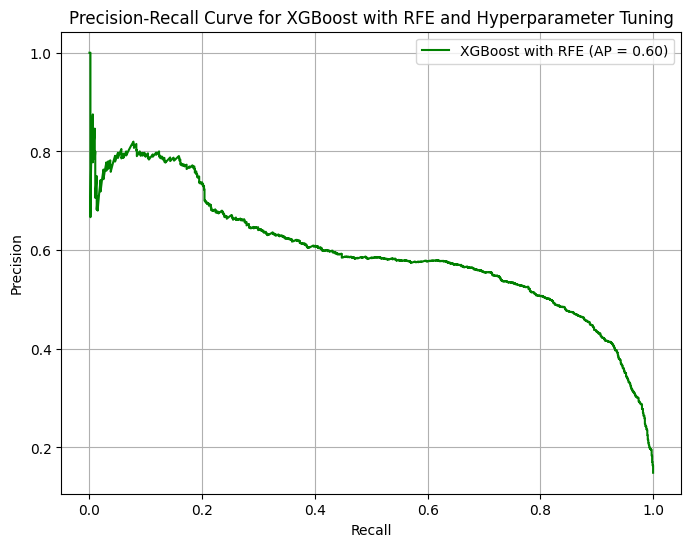

In [73]:
y_pred_prob_xgb_rfe_tuned = best_xgb.predict_proba(X_valid_rfe_xgb)[:, 1]
precision_xgb_rfe_tuned, recall_xgb_rfe_tuned, _ = precision_recall_curve(y_valid_encoded, y_pred_prob_xgb_rfe_tuned)
average_precision_xgb_rfe_tuned = average_precision_score(y_valid_encoded, y_pred_prob_xgb_rfe_tuned)

# Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_xgb_rfe_tuned, precision_xgb_rfe_tuned, label=f"XGBoost with RFE (AP = {average_precision_xgb_rfe_tuned:.2f})", color="green")
plt.title("Precision-Recall Curve for XGBoost with RFE and Hyperparameter Tuning")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.grid()
plt.show()


- The Average Precision (AP) score of 0.60 indicates that the model has a moderate performance in terms of precision and recall. A higher AP score would suggest better overall performance.
- The curve shows a typical trade-off between precision and recall. As recall increases, precision tends to decrease, and vice versa. This is because the model is more likely to include more false positives as it tries to capture more true positives.
- As recall increases, precision starts to decline. This indicates that the model is including more false positives along with true positives.


In [74]:
y_pred_train = best_xgb.predict(X_train_rfe_xgb)
print("Training F1 Macro Score:", f1_score(y_train_encoded, y_pred_train, average='macro'))
print("Validation F1 Macro Score:", f1_score(y_valid_encoded, y_pred_xgb_rfe, average='macro'))


Training F1 Macro Score: 0.7895097887796427
Validation F1 Macro Score: 0.7724330806866431


- model is not overfitting as the difference is 0.01%.

In [75]:
final_xgb_model = XGBClassifier(**best_params)
final_xgb_model.fit(X_train_rfe_xgb, y_train_encoded)

# Save the final model to a file
joblib.dump(final_xgb_model, 'final_xgb_model.pkl')

# Load the model when you need it
loaded_model = joblib.load('final_xgb_model.pkl')

[Back to Table of Contents](#1)


# <a id="test"></a> 10.Test Data Processing, Feature Selection, and Model Prediction with XGBoost

In [78]:
X_test = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")

In [79]:
X_test.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,2009-11-21,36,management,single,tertiary,no,7,no,no,NaN,20,1,-1,0,NaN
1,2010-02-04,30,unemployed,married,tertiary,no,1067,no,no,cellular,78,2,-1,0,NaN
2,2010-07-28,32,blue-collar,single,secondary,no,82,yes,no,cellular,86,4,-1,0,NaN
3,2010-06-09,38,admin.,married,primary,no,1487,no,no,NaN,332,2,-1,0,NaN
4,2008-03-02,59,management,married,tertiary,no,315,no,no,cellular,591,1,176,2,failure


In [80]:
X_test['last contact date'] = pd.to_datetime(X_test['last contact date'])

In [81]:
X_test['year'] = X_test['last contact date'].dt.year
X_test['month'] = X_test['last contact date'].dt.month_name()
X_test['day'] = X_test['last contact date'].dt.day
X_test['day_of_week'] = X_test['last contact date'].dt.day_name()


In [82]:
X_test = X_test.drop(columns=['last contact date','year'])

In [83]:
X_test_transformed = preprocessor.transform(X_test)
X_test_rfe = rfe_xgb.transform(X_test_transformed) 
y_test_pred = final_xgb_model.predict(X_test_rfe)  

submission_df = pd.DataFrame({
    "id": range(0,X_test.shape[0]), 
    'target': y_test_pred
})

In [84]:
submission_df.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1


In [85]:
submission_df['target'] = np.where(submission_df['target'] == 1, 'yes', 'no')
submission_df.to_csv('submission.csv', index=False)

In [86]:
submission_df.head()

,id,target
0,0,no
1,1,no
2,2,no
3,3,no
4,4,yes
